In [1]:
%matplotlib inline
import scipy.misc
import tensorflow as tf
import numpy as np
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pdb
import gzip
import pickle

In [2]:
from MLPWD import *
TYPE=tf.float32
path="...."

conf=pickle.load(open(path+'MNISTWD.pkl','rb'))[0]
bs= conf['batch_size']


print ("Loading  data")
# tr,va,te = cifar10WithValid()
with gzip.open('/home/hani/Data/mnist.pkl.gz', 'rb') as f:
    try:
        tr, va, te = pickle.load(f, encoding='latin1')
    except:
        tr, va, te = pickle.load(f)

print(va[0].shape[0],te[0].shape[0])
# assert (va[0].shape[0]%bs ==0) & (te[0].shape[0]%bs ==0)

print ("Data was loaded")
sampleSize,featureSize = tr[0].shape
validSize=va[0].shape[0]
testSize =te[0].shape[0]
batch_order = np.arange(int(sampleSize / conf['batch_size']))



mode = tf.Variable(1,trainable=False,name='mode') # 1:tr 2:va 3:te
index = tf.Variable(0,trainable=False,name='index')
# learning_rate = tf.Variable(conf['learning_rate'],trainable=False,name='learning_rate')
batch = tf.Variable(0, dtype='int32',trainable=False)
learning_rate = tf.train.exponential_decay(
      conf['learning_rate'],                # Base learning rate.
      batch * conf['batch_size'],           # Current index into the dataset.
      sampleSize,                           # Decay step.
      conf['lrdr'],                # Decay rate.
      staircase=False)
# pdb.set_trace()
trXTensor = tf.Variable(tr[0],name='trXTensor',trainable=False,dtype=TYPE)
vaXTensor = tf.Variable(va[0],name='vaXTensor',trainable=False,dtype=TYPE)
teXTensor = tf.Variable(te[0],name='teXTensor',trainable=False,dtype=TYPE)

trYTensor = tf.Variable(tr[1],name='trYTensor',trainable=False)
vaYTensor = tf.Variable(va[1],name='vaYTensor',trainable=False)
teYTensor = tf.Variable(np.asarray(te[1],'int64'),name='teYTensor',trainable=False)


bsValTe=100
valbatch_order = np.arange(int(validSize / bsValTe))
tebatch_order = np.arange (int(testSize / bsValTe))

x = tf.cond(tf.equal(mode,1),
             lambda:tf.slice(trXTensor,[index*bs,0],[bs,featureSize]), 
             lambda:tf.cond(tf.equal(mode,2), 
                             lambda:tf.slice(vaXTensor,[index*bsValTe,0],[bsValTe,featureSize]),
                             lambda:tf.slice(teXTensor,[index*bsValTe,0],[bsValTe,featureSize])))

y = tf.cond(tf.equal(mode,1),
             lambda:tf.slice(trYTensor,[index*bs],[bs]), 
             lambda:tf.cond(tf.equal(mode,2), 
                             lambda:tf.slice(vaYTensor,[index*bsValTe],[bsValTe]),
                             lambda:tf.slice(teYTensor,[index*bsValTe],[bsValTe])))

model = MLPWD(x,y,conf, n_in=featureSize, outClass=10)           
# model = RMLPBN(x,y,conf, n_in=featureSize, outClass=10)           

if conf['optim'] =='rmsprop':
    optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate,decay=conf['decay_rate']).minimize(model.cost,
                                                                                              global_step=batch)
else:
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(model.cost,
                                                                                        global_step=batch)

init_op = tf.group(tf.global_variables_initializer())

sess =tf.Session()

sess.run(init_op)
saver = tf.train.Saver(max_to_keep=2)
bestRes=()
bestValid = -np.inf
trCost=0
clrDec = 0
lrPatience=1
validFreq= 1
c_learning_rate = conf['learning_rate']


epoch= 0
output={
  'optimizer':optimizer,
  'lr':learning_rate,
  'cost': model.cost
  # 'tmp': model.layers[1].tmp
}

Loading  data
10000 10000
Data was loaded
hiddenwxsd0 has: 254956800


In [6]:
saver = tf.train.Saver()
# new_saver = tf.train.import_meta_graph('/home/hani/ModelOut/dynamicfiltering/good/mnistWx-17.meta')
saver.restore(sess, path+'MNISTWD-100')

INFO:tensorflow:Restoring parameters from /home/hani/ModelOut/dynamicfiltering/WD/MNIST/48-47/MNISTWD-100


In [7]:
testSize=te[0].shape[0]
tebatch_order = np.arange (int(testSize / 100))
testAccuracy=0
for batch in tebatch_order:
    testAccuracy+= sess.run(model.sum_accuracy, feed_dict={index: batch, mode:3})
100*(testAccuracy/testSize)

98.469999999999999

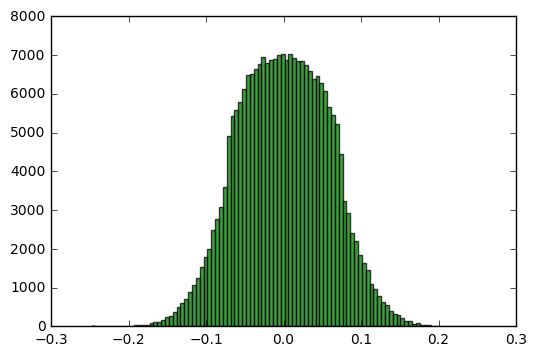

In [8]:
arr = sess.run(model.layers[0].WL)
n, bins, patches = plt.hist(arr.reshape([-1]), 100, facecolor='g', alpha=0.75)
plt.show()

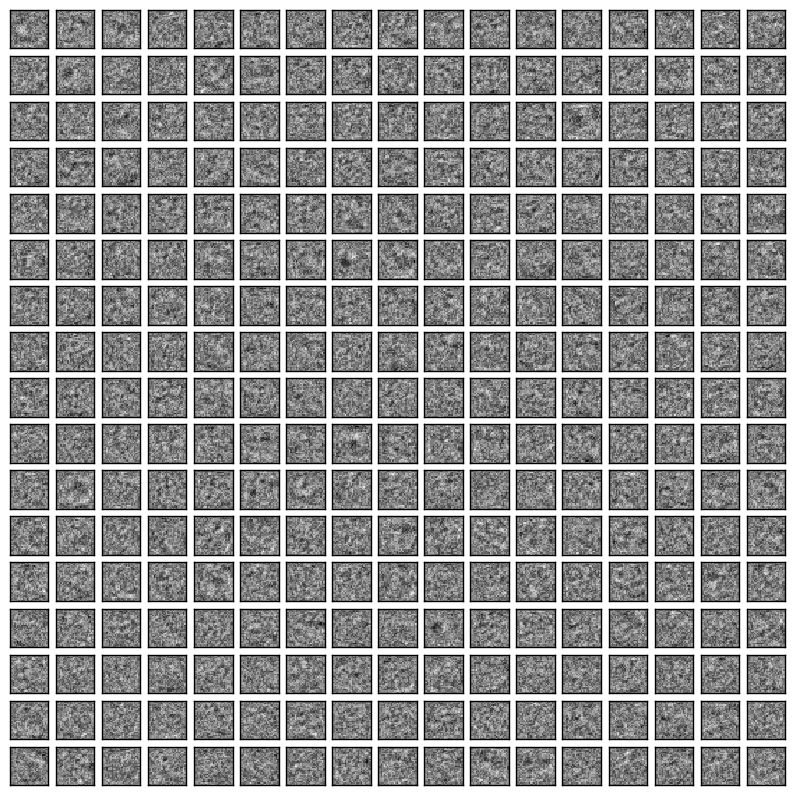

In [12]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(17, 17,figsize=(10, 10))
arr = sess.run(model.layers[0].WL)
vmin, vmax = arr.min(), arr.max()
counter=0

for coef, ax in zip(arr.T, axes.ravel()):
        ax.matshow(coef.reshape(28, 28), cmap=plt.cm.gray, vmin= 1*vmin,
               vmax=1*vmax)
        ax.set_xticks(())
        ax.set_yticks(())

plt.show()

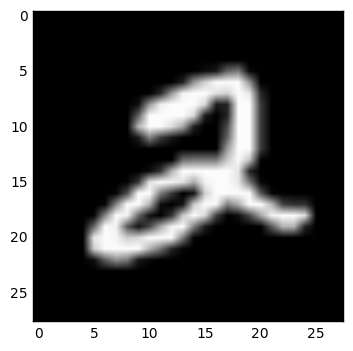

In [18]:

import scipy.misc

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

imIndex=5
im = sess.run(x,feed_dict={index: 0, mode:1})[imIndex]
plt.imshow(im.reshape([28,28]), cmap='gray')
plt.show()

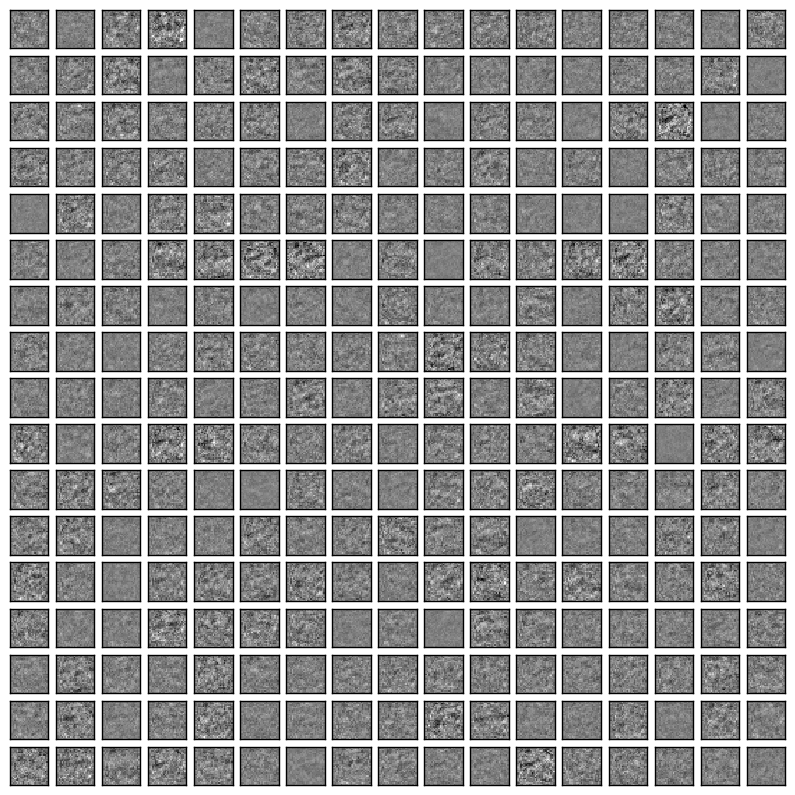

In [21]:
 #*** VISUALIZE ARR FILTERS
# # LETTER 2
import matplotlib.pyplot as plt
fig, axes = plt.subplots(17, 17,figsize=(10, 10))
arr = sess.run(model.layers[0].Wx, feed_dict={index: 0, mode:1})[imIndex] 
# use global min / max to ensure all weights are shown on the same scale
vmin, vmax = arr.min(), arr.max()
counter=0
for coef, ax in zip(arr.T, axes.ravel()):
        ax.matshow(coef.reshape(28, 28), cmap=plt.cm.gray, vmin= 0.8*vmin,
               vmax=0.8*vmax)
        ax.set_xticks(())
        ax.set_yticks(())

plt.show()